Unsupervised learning refers to the family of machine learning problems where the training data consists of a set of input vectors x without any corresponding target values. Typical goals for doing unsupervised learning are:

  - **Dimensionality reduction**: finding a lower-dimensional representation of the data that retains as much of the relevant information as possible.
  - **Clustering**: identifying distinct groups of data points.
  - **Density estimation**: estimating the probability density function 
  $p(x)$ of the random variable $x$. These methods are often used for anomaly detection and synthetic data generation (e.g. text completion, image inpainting).

  ## Dimensionality Reduction


  Given an unsupervised data set $S = \{ x_1, \ldots, x_n \}$ for $d-$dimensional observations $x_i$, we want to find a function $f$ that maps each high-dimensional data point $x_i$ to a lower-dimensional point $z_i = f(x_i)$, such that the $z_i$ are as informative as possible about the $x_i$.

  Assume we want to project the data onto a one-dimensional subspace via a vector $u_1$ with unit norm (i.e., $u_1^T u_1=1$). The mean of the projected data is then given by

  $$ \bar{z} = \frac{1}{n} \sum_{i=1}^m z_i = \frac{1}{n} \sum_{i=1}^m u_1^T x_i = u_1^T \left( \frac{1}{n} \sum_{i=1}^m x_i \right) = u_1^T \bar{x} $$

  where $\bar{x}$ is the mean of the original data. The variance of the projected data is given by

  $$ \frac{1}{n} \sum_{i=1}^m (z_i - \bar{z})^2 = \frac{1}{m} \sum_{i=1}^m (u_1^T x_i - u_1^T \bar{x})^2 = u_1^T \left( \frac{1}{m} \sum_{i=1}^m (x_i - \bar{x})(x_i - \bar{x})^T \right) u_1 = u_1^T S u_1 $$

  where $S$ is the covariance matrix of the original data. We aim to maintain the factors of variation as much as possible, hence we would like to solve the projection vector such that:

\begin{align*}
\max_{u_1} u_1^T S u_1 \quad \text{subject to} \quad u_1^T u_1 = 1.
\end{align*}

  This is a constrained optimization problem, which can be solved using Lagrange multipliers. The Lagrangian is given by

\begin{align*}
\mathcal{L}(u_1, \lambda) = u_1^T S u_1 - \lambda (u_1^T u_1 - 1).
\end{align*}

Setting the derivative with respect to $u_1$ to zero yields

\begin{align*}
\frac{\partial \mathcal{L}}{\partial u_1} = 2 S u_1 - 2 \lambda u_1 = 0
\end{align*}

Hence $u_1$ is an eigenvector of $S$ with eigenvalue $\lambda$. Since $u_1$ is constrained to have unit norm, we can simply choose the eigenvector with the largest eigenvalue. This is known as the **principal component** of the data. The corresponding eigenvalue is the variance of the data projected onto the principal component. We can define additional principal components by choosing the eigenvectors with the next largest eigenvalues, subject to the constraint that the eigenvectors are orthogonal to the previously chosen ones. The resulting vectors are known as the **principal axes** of the data. Consider the remarkable fact about the Positive Semi-Definite (PSD) matrix $S$:

\begin{align*}
  S = \sum_{i=1}^d \lambda_i u_i u_i^T
\end{align*}

where $\lambda_i$ and $u_i$ are the eigenvalues and eigenvectors of $S$, respectively. This is known as the **spectral decomposition** of $S$. If we want to project the data onto a $k$-dimensional subspace, we simply choose the $k$ eigenvectors with the largest eigenvalues and form a matrix $U_k$ with these eigenvectors as columns. The projected data is then given by $Z = U_k^T X$. The representation $Z$ will cover the following percentage of the variance of the original data:

\begin{align*}
  \frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^d \lambda_i} \times 100.
\end{align*}

Hence one can determine $k$ by choosing a threshold of preference and projecting data to a dimensionality where that much variance can be preserved. The source code below reduces the dimensionality of the Iris data set using PCA and depicts its spectral decomposition.

4


<BarContainer object of 4 artists>

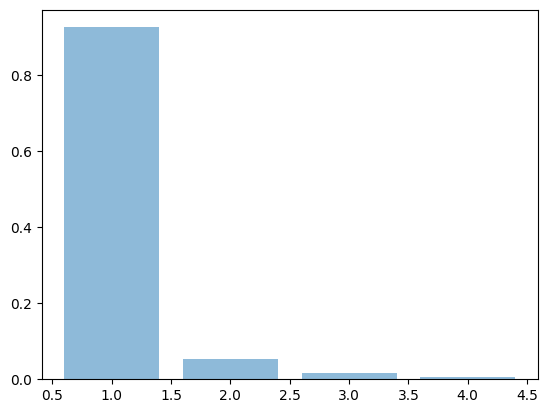

In [1]:
# Iris data set example
from sklearn import datasets   
import numpy as np
import matplotlib.pyplot as plt

iris = datasets.load_iris()

X = iris.data
y = iris.target

print(X.shape[1])

# Compute the covariance matrix
cov_mat = np.cov(X.T)

# Compute the eigenvalues and eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Plot the variance explained ratio of the eigenvalues
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1, 5), var_exp, alpha=0.5, align='center',
        label='individual explained variance')



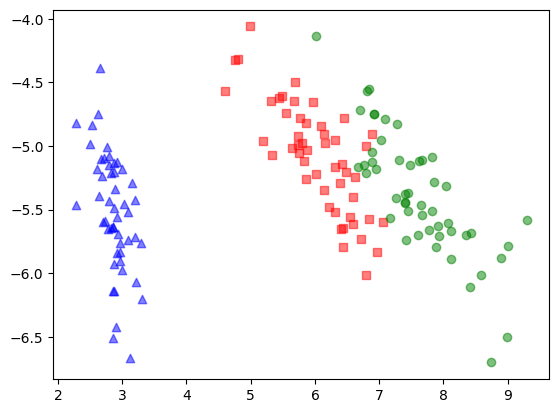

In [4]:
# Reduce the dimensionality of the data set to two
X_reduced = X.dot(eigen_vecs[:, :2])

# Plot the reduced data set

for label, marker, color in zip(
        range(0, 3), ('^', 's', 'o'), ('blue', 'red', 'green')):
    plt.scatter(X_reduced[y == label, 0], X_reduced[y == label, 1],
                marker=marker, color=color, alpha=0.5, label=label) 
     

## Clustering

Clustering refers to the task of identifying groups of similar data points. The goal is to partition the data into subsets such that points in the same subset are similar to each other, while points in different subsets are dissimilar. The similarity between two points is typically measured using a distance metric, such as the Euclidean distance.

The most common clustering algorithm is **k-means clustering**. It partitions the data into $k$ subsets, or clusters, by minimizing the within-cluster sum of squares: 

\begin{align*}
\min_{C_1, \ldots, C_k} \sum_{j=1}^k \sum_{i \in C_j} || x_i - \mu_j ||^2
\end{align*}

where $C_1, \ldots, C_k$ are the clusters, $\mu_j$ is the mean of cluster $C_j$, and $|| x_i - \mu_j ||^2$ is the squared Euclidean distance between data point $x_i$ and the mean $\mu_j$ of its cluster. The algorithm alternates between two steps:

  1. Assign each data point to the cluster with the nearest mean.
  2. Update the means of the clusters to be the centroids of the data points assigned to them.

The algorithm is guaranteed to converge to a local minimum, but it does not necessarily find the global minimum. The source code below illustrates the k-means algorithm on the Iris data set.

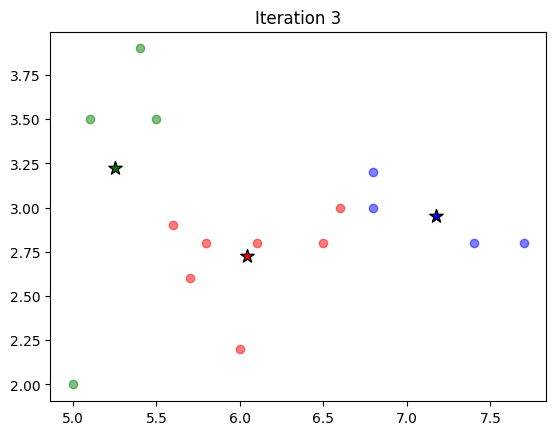

In [14]:
# k-means clustering on Iris data set

from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist

class KMeans(object):

    def __init__(self, data, k=3, tol=1e-9):
        self.k = k
        self.tol = tol
        self.data = data
        self.clusters = np.zeros(len(self.data))

        # Initialize the centroids to k random points in the data set
        idx = np.random.permutation(len(self.data))
        self.centroids = self.data[idx[:self.k]]

    def update_clusters(self):

        # Find the distance between each point and each cluster
        dist = cdist(self.data, self.centroids, 'euclidean')   

        # Assign each point to the nearest cluster
        self.clusters = np.argmin(dist, axis=1)

        # Update the centroids
        centroids_old = self.centroids.copy()

        for i in range(self.k):
            self.centroids[i] = \
                 np.mean(self.data[self.clusters == i], axis=0)

        # Check if the centroids have converged
        return np.allclose(centroids_old, self.centroids, self.tol)

    def visualize_clusters(self,titlestr=""):
        colors = ['r', 'g', 'b', 'y', 'c', 'm']

        plt.figure()
        for i in range(self.k):
            plt.scatter(self.data[self.clusters == i, 0], 
                        self.data[self.clusters == i, 1],
                        marker='o', color=colors[i], alpha=0.5)
            
            plt.scatter(self.centroids[i, 0], self.centroids[i, 1], 
                        marker='*', edgecolor='k', color=colors[i], s=100)
        
        plt.title(titlestr)
        plt.show()

idx = np.random.permutation(150)
Xmini = X[idx[:15]]
km = KMeans(k=3, data=Xmini)

for i in range(20):
    plot = km.visualize_clusters(titlestr="Iteration "+str(i))
    converged=km.update_clusters()
    if converged:
        break



## Density Estimation

There are some real-world problems where we are interested in understanding the process that generated the data. For instance, we may want to generate text to communicate with users via natural language or generate images to visualize fictional cases, as done nowadays by deep fakes. Estimating the data generating process, i.e. the probability density function $p(x)$, can also be used for anomaly detection. If the probability of a data point is very low, it is likely to be an anomaly. The state-of-the-art approach to density estimation is deep generative models. 

Let us start with a simple case where the data is generated by a mixture of Gaussians. The assumed data generating process for each i.i.d. sample $x$ is given by

\begin{align*}
  z &\sim \text{Categorical}(\pi_1, \ldots, \pi_k), \\
  x | z &= \prod_{j=1}^k \mathcal{N}(x | \mu_j, \Sigma_j)^{z_j},
\end{align*}

where $z$ is a $k-$ dimensional one-hot vector, $\pi_j$ is the prior probability of component $j$, $\mu_j$ is the mean of component $j$, and $\Sigma_j$ is the covariance matrix of component $j$. Note the following two remarkable properties of this model:

 - The variable $z$ a **latent variable**. We do not observe it directly. We aim to infer it from the observed data $x$.
 - The posterior distribution $p(z| x)$ of an observed data point $x$ will assign it to clusters **probabilistically**. Hence, our model will allow **soft assignments** of data points to clusters.
 - The variables $\mu_j$ and $\Sigma_j$ are deterministic quantities and are shared across all data points. Hence we call them **parameters** of the model.

 We are interested in two tasks:

  1. **Inference**: Given a new data point $x$, we want to infer the posterior distribution $p(z | x)$.
  2. **Learning**: Given the data set $S=\{x_1, \ldots, x_m \}$, we want to learn the parameters $\pi_j, \mu_j, \Sigma_j$ of the model.

 For a fixed set of parameters $\pi_j, \mu_j, \Sigma_j$, we can compute the posterior distribution $p(z | x)$ of a given observation $x$ using Bayes' rule:

\begin{align*}
  p(z | x) = \frac{p(x | z) p(z)}{p(x)} = \frac{\prod_{j=1}^k \mathcal{N}(x | \mu_j, \Sigma_j)^{z_j} \pi_j}{\sum_{z'} \prod_{j=1}^k \mathcal{N}(x | \mu_j, \Sigma_j)^{z'_j} \pi_j}
\end{align*}
The sum in the denominator is over all possible values of $z$. Since $z$ is a one-hot vector, there are only $k$ possible values with $z_j = 1$ and $z_{j'} = 0$ for $j' \neq j$. For each possibility, only one term in the product is non-zero. Hence, we can simplify it to

\begin{align*}
 \sum_{z'} \prod_{j=1}^k \mathcal{N}(x | \mu_j, \Sigma_j)^{z'_j} \pi_j = \sum_{j=1}^k \mathcal{N}(x | \mu_j, \Sigma_j) \pi_j.
\end{align*}

Plugging this result into the formula above, we attain the posterior distribution $p(z | x)$ as a categorical distribution with probabilities assigned to each component $j$ given by

\begin{align*}
  p(z_j = 1 | x) = \frac{\mathcal{N}(x | \mu_j, \Sigma_j) \pi_j}{\sum_{j'=1}^k \mathcal{N}(x | \mu_{j'}, \Sigma_{j'}) \pi_{j'}}.
\end{align*}

We can learn the parameters $\pi_j, \mu_j, \Sigma_j$ by maximum likelihood estimation. However, we also need to account for the randomness over the latent variable $z$. In the context of learning the parameters, $z$ is called a **nuisance variable**. We can **marginalize** out the latent variable $z$ by summing over all possible values of $z$ to obtain a likelihood function for the parameters $\mu_j, \Sigma_j$:

\begin{align*}
  \log p(S | \mu_j, \Sigma_j) = \sum_{i=1}^m \log \sum_{z_i} p(x_i | z_i, \mu_j, \Sigma_j) p(z_i) = \sum_{i=1}^m \log \sum_{j=1}^k \mathcal{N}(x_i | \mu_j, \Sigma_j) \pi_j.
\end{align*}

As practiced before, let us take the derivative of the log-likelihood with respect to the parameters, set it to zero, and solve. Let us do it first for the means:
\begin{align*}
  \frac{\partial \log p(S | \mu_j, \Sigma_j)}{\partial \mu_j} &= \sum_{i=1}^m \frac{\mathcal{N}(x_i | \mu_j, \Sigma_j) \pi_j}{\sum_{j'=1}^k \mathcal{N}(x_i | \mu_{j'}, \Sigma_{j'}) \pi_{j'}} \Sigma_j^{-1} (x_i - \mu_j) = 0 \\
  \Rightarrow & \sum_{i=1}^m \frac{\mathcal{N}(x_i | \mu_j, \Sigma_j) \pi_j}{\sum_{j'=1}^k \mathcal{N}(x_i | \mu_{j'}, \Sigma_{j'}) \pi_{j'}} (x_i - \mu_j) = 0 \\
  \Rightarrow & \sum_{i=1}^m \frac{\mathcal{N}(x_i | \mu_j, \Sigma_j) \pi_j}{\sum_{j'=1}^k \mathcal{N}(x_i | \mu_{j'}, \Sigma_{j'}) \pi_{j'}} x_i = \sum_{i=1}^m \frac{\mathcal{N}(x_i | \mu_j, \Sigma_j) \pi_j}{\sum_{j'=1}^k \mathcal{N}(x_i | \mu_{j'}, \Sigma_{j'}) \pi_{j'}} \mu_j \\
  \Rightarrow & \mu_j = \frac{\sum_{i=1}^m \frac{\mathcal{N}(x_i | \mu_j, \Sigma_j) \pi_j}{\sum_{j'=1}^k \mathcal{N}(x_i | \mu_{j'}, \Sigma_{j'}) \pi_{j'}} x_i}{\sum_{i=1}^m \frac{\mathcal{N}(x_i | \mu_j, \Sigma_j) \pi_j}{\sum_{j'=1}^k \mathcal{N}(x_i | \mu_{j'}, \Sigma_{j'}) \pi_{j'}}} \\
  \Rightarrow & \mu_j = \frac{ \sum_{i=1}^m \gamma(z_{ij}) x_i}{ \sum_{i=1}^m \gamma(z_{ij}) }
\end{align*}
where
\begin{align*}
  \gamma(z_{ij}) = \frac{\mathcal{N}(x_i | \mu_j, \Sigma_j) \pi_j}{\sum_{j'=1}^k \mathcal{N}(x_i | \mu_{j'}, \Sigma_{j'}) \pi_{j'}}.
\end{align*}
Remember that this term is the posterior probability of component $j$ given data point $x_i$, that is $p(z_j = 1 | x)$. In the algorithmic literature, this term is called the **responsibility** of component $j$ for data point $x_i$. It is the probability that component $j$ generated data point $x_i$.

Let us do the same for the covariance matrices:
\begin{align*}
  \frac{\partial \log p(S | \mu_j, \Sigma_j)}{\partial \Sigma_j} &= \sum_{i=1}^m \gamma(z_{ij}) \left( \frac{1}{2} \Sigma_j^{-1} - \frac{1}{2} \Sigma_j^{-1} (x_i - \mu_j) (x_i - \mu_j)^T \Sigma_j^{-1} \right) = 0\\
  \Rightarrow \Sigma_j &= \frac{\sum_{i=1}^m \gamma(z_{ij}) (x_i - \mu_j) (x_i - \mu_j)^T}{\sum_{i=1}^m \gamma(z_{ij})}.
\end{align*}

Denote $m_j = \sum_{i=1}^m \gamma(z_{ij})$. We can think of this quantity as the **effective size** of cluster $j$. We can now compute the maximum likelihood estimates for the parameters $\pi_j$ of the mixture model:

\begin{align}
  \frac{\partial \log p(S | \mu_j, \Sigma_j) +\lambda \Big ( \sum_{j=1}^K \pi_j - 1 \Big )}{\partial \pi_j} &= \sum_{i=1}^m \frac{\mathcal{N}(x_i | \mu_j, \Sigma_j)}{\sum_{j'=1}^k \mathcal{N}(x_i | \mu_{j'}, \Sigma_{j'}) \pi_{j'}} + \lambda = 0 \\
  \Rightarrow \pi_j &= \frac{\sum_{i=1}^m \mathcal{N}(x_i | \mu_j, \Sigma_j)}{\sum_{i=1}^m \sum_{j'=1}^k \mathcal{N}(x_i | \mu_{j'}, \Sigma_{j'}) \pi_{j'}} \\
     &= \frac{m_j}{\sum_{j'=1}^k m_{j'}}\\
    & = \frac{m_j}{m}.
\end{align}
Above, once again we use a Lagrange multiplier $\lambda$ to enforce the constraint that the $\pi_j$ sum to one.

Notice above that we can calculate the posterior probabilities $p(z_j = 1 | x)$, i.e the responsibilities $\gamma(z_{ij})$, analytically for fixed parameters $\mu_j, \Sigma_j, \pi_j$. In turn, we need to fix the responsibilities $\gamma(z_{ij})$ to calculate the maximum likelihood estimates for the parameters $\mu_j, \Sigma_j, \pi_j$.  The calculation of the posterior probabilities is called the **E-step** because it involves calculating the expectation of the log-likelihood with respect to the posterior distribution $p(z | x)$. The update of the parameters is called the **M-step** because it maximizes the expectation of the log-likelihood with respect to the posterior distribution $p(z | x)$. We obtain an algorithm that learns by iterating between the E-step and the M-step:

  1. Initialize the parameters $\mu_j, \Sigma_j, \pi_j$.
  2. **E-Step:** Compute the responsibilities $\gamma(z_{ij})$:
  \begin{align*}
    \gamma(z_{ij}) &:= \frac{\mathcal{N}(x_i | \mu_j, \Sigma_j) \pi_j}{\sum_{j'=1}^k \mathcal{N}(x_i | \mu_{j'}, \Sigma_{j'}) \pi_{j'}} \\
  \end{align*}
  3. **M-Step:** Update the parameters $\mu_j, \Sigma_j, \pi_j$ using the responsibilities $\gamma(z_{ij})$.
  \begin{align*}
       m_j &:= \sum_{i=1}^m \gamma(z_{ij})\\
       \mu_j &= \frac{ \sum_{i=1}^m \gamma(z_{ij}) x_i}{ m_j } \\
       \Sigma_j :=& \frac{\sum_{i=1}^m \gamma(z_{ij}) (x_i - \mu_j) (x_i - \mu_j)^T}{m_j} \\
       \pi_j :=& \frac{m_j}{m}
  \end{align*}
  4. Repeat until convergence.

This algorithms is known as the **expectation maximization (EM) algorithm**. It is guaranteed to converge to a local maximum of the likelihood function. The source code below illustrates the EM algorithm on the Iris data set.

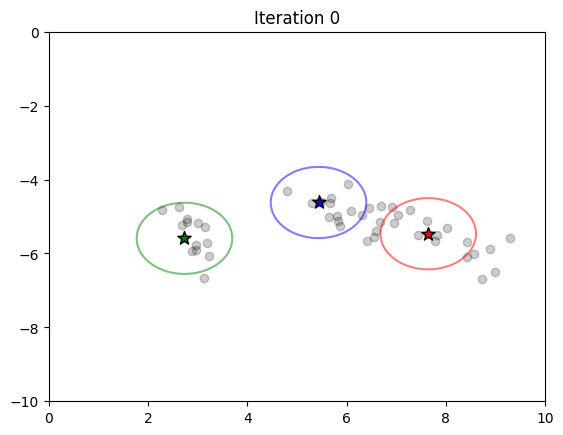

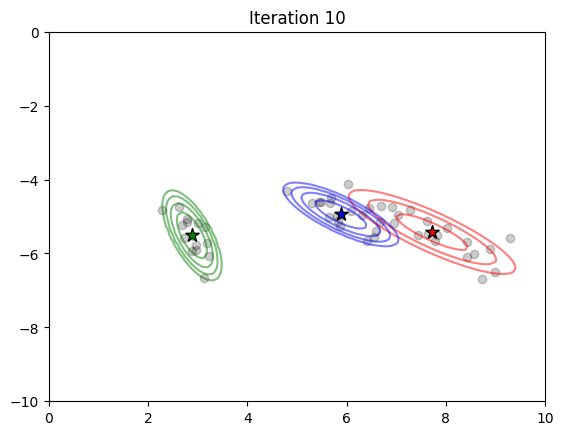

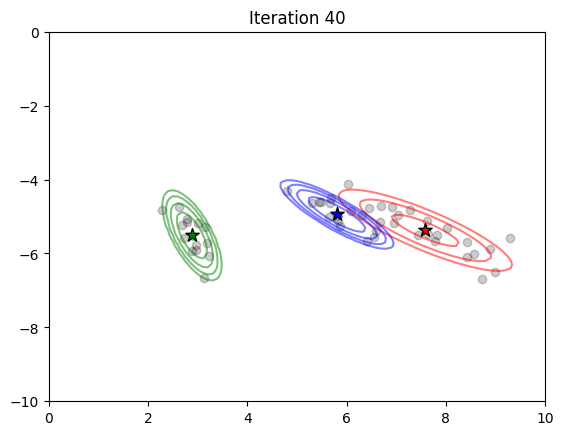

In [12]:
from scipy.stats import multivariate_normal
import matplotlib.gridspec as gridspec 
import numpy as np

class MixtureOfGaussians(object):
    def __init__(self, data, k=3, tol=1e-9):
        self.k = k
        self.tol = tol
        self.data = data
        self.clusters = np.zeros([len(self.data), k])

        # Initialize the means to k random points in the data set
        idx = np.random.permutation(len(self.data))
        self.means = self.data[idx[:self.k]]

        # Initialize the covariance matrices to the identity matrix
        self.covariances = np.zeros((self.k, 
                            self.data.shape[1], self.data.shape[1]))
        for i in range(self.k):
            self.covariances[i] = np.eye(self.data.shape[1])

        # Initialize the mixing coefficients to be uniform
        self.mixing_coefficients = np.ones(self.k) / self.k

    def E_step(self):

        # Compute the probability of each point belonging to each cluster
        for i in range(self.k):
            self.clusters[:, i] = \
                self.mixing_coefficients[i] * multivariate_normal.pdf(self.data, \
                        self.means[i], self.covariances[i])

        # Normalize the probabilities so that each point has a total probability of 1
        self.clusters /= self.clusters.sum(axis=1, keepdims=True)

        # Update the mixing coefficients
        self.mixing_coefficients = self.clusters.mean(axis=0)

    def M_step(self):
            
        # Update the means
        self.means = \
            self.clusters.T.dot(self.data) / self.clusters.sum(axis=0, keepdims=True).T

        # Update the covariance matrices
        for i in range(self.k):
            Z = (self.data - self.means[i]) * np.sqrt(self.clusters[:, i].reshape(-1, 1))
            self.covariances[i] = Z.T.dot(Z) / self.clusters[:, i].sum() \
                      + np.eye(self.data.shape[1]) * 1e-8

    def visualize_clusters(self,titlestr=""):
        colors = ['r', 'g', 'b', 'y', 'c', 'm']

        plt.figure()
        plt.scatter(self.data[:, 0], self.data[:, 1], 
                    marker='o', color='k', alpha=0.2)

        xx, yy = np.mgrid[-10:10:.1, -10:10:.1]
        data = np.dstack((xx, yy))

        for i in range(self.k):
            rv = multivariate_normal(self.means[i], self.covariances[i])
            z = rv.pdf(data)
            plt.contour(xx, yy, z, levels=[0.1,0.2,0.4,0.8,1.6], 
                colors=colors[i], alpha=0.5)
            plt.scatter(self.means[i, 0], self.means[i, 1], 
                marker='*', edgecolor='k', color=colors[i], s=100)
            plt.xlim([0, 10])
            plt.ylim([-10, 0])
        plt.title(titlestr)
        plt.show()        
        
    
idx = np.random.permutation(150)
Xmini = X_reduced[idx[:50]]
mog = MixtureOfGaussians(k=3, data=Xmini)

for i in range(50):
    if i % 10 == 0:
        plot = mog.visualize_clusters(titlestr="Iteration "+str(i))
    mog.E_step()
    mog.M_step()
